# Import neccessary Packages and Set up the Environment
- import neccessary packages, most especially HuggingFace, Torch, and LangChain
- we will also import and install Google's API in order to get some data related to YouTube Comments
- finally, we will specify which LLM we want to work with locally and import an OpenAI API key, should we want to work with their LLMs

In [236]:
! pip install google-api-python-client
! pip install langchain --user
! pip install openai --user
! pip install tiktoken


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python -m pip install --upgrade pip


In [1]:
import os, re, numpy as np, pandas as pd
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, DBSCAN

from googleapiclient.discovery import build

from transformers import pipeline, AutoTokenizer
from sentence_transformers import SentenceTransformer
import torch

from langchain import OpenAI, PromptTemplate, LLMChain, HuggingFacePipeline, FewShotPromptTemplate
from langchain.chains.summarize import load_summarize_chain
from langchain.docstore.document import Document
from langchain.chains.mapreduce import MapReduceChain
from langchain.text_splitter import RecursiveCharacterTextSplitter

from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
import umap

2023-05-05 18:14:02.107288: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-05 18:14:02.883947: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# import OpenAI Key

with open("open_ai_credentials.txt") as f:
    open_api_key = f.read()
    
os.environ["OPENAI_API_KEY"] = open_api_key

# Create a Dataset
- import comments from YouTube videos
- look at some examples

In [3]:
def get_video_comments(video_id, api_key):
    # empty list for storing reply
    replies = []
 
    # creating youtube resource object
    youtube = build('youtube', 'v3',
                    developerKey=api_key)
 
    # retrieve youtube video results
    video_response=youtube.commentThreads().list(
        part='snippet',
        maxResults=100,
        videoId=video_id
    ).execute()
 
    # iterate video response
    results = []
    while video_response:
       
        # extracting required info
        # from each result object
        for item in video_response['items']:
           
            datum = {}
            datum['id'] = item['id']
            datum['comment'] = item['snippet']['topLevelComment']['snippet']['textOriginal']
            datum['author'] = item['snippet']['topLevelComment']['snippet']['authorDisplayName']
            datum['author_channel'] = item['snippet']['topLevelComment']['snippet']['authorChannelId']['value']
            datum['like_count'] = item['snippet']['topLevelComment']['snippet']['likeCount']
            datum['published_at'] = item['snippet']['topLevelComment']['snippet']['publishedAt']
            datum['coversation_id'] = item['id']
            results.append(datum)
            if item['snippet']['totalReplyCount'] > 0:
                results.extend(get_all_top_level_comment_replies(item['id'], [], None)) 
 
        # Again repeat
        if 'nextPageToken' in video_response:
            video_response = youtube.commentThreads().list(
                    part = 'snippet',
                    pageToken = video_response['nextPageToken'],
                    videoId = video_id
                ).execute()
        else:
            return results

In [4]:
def get_all_top_level_comment_replies(top_comment_id, replies, token):
    
    # creating youtube resource object
    youtube = build('youtube', 'v3',
                    developerKey=api_key)
    
    replies_response=youtube.comments().list(part='snippet',
                                               maxResults=100,
                                               parentId=top_comment_id,
                                               pageToken=token).execute()

    for item in replies_response['items']:
        datum = {}
        datum['id'] = item['id']
        datum['comment'] = item['snippet']['textOriginal']
        datum['author'] = item['snippet']['authorDisplayName']
        datum['author_channel'] = item['snippet']['authorChannelId']['value']
        datum['like_count'] = item['snippet']['likeCount']
        datum['published_at'] = item['snippet']['publishedAt']
        datum['coversation_id'] = top_comment_id
        replies.append(datum)

    if "nextPageToken" in replies_response: 
        return get_all_top_level_comment_replies(top_comment_id, replies, replies_response['nextPageToken'])
    else:
        return replies

In [5]:
# Possible YouTube videos that we will look at for Analysis

video_id = "Lwx-2R9swDg" # Be All You Can Be - U.S. Army's new brand trailer - U.S. Army
#video_id = "-ZMzfihqOkQ" # What Army Snipers Go Through At Sniper School - insider business
#video_id = "nV8UZJNBY6Y" # Adele - The Final Carpool Karaoke
#video_id = "kLMMxgtxQ1Y" # GOP- Beat Biden AI-generated images

If scraping new data run the following...

In [7]:
with open("youtube_credentials.txt") as f:
    api_key = f.read()

In [8]:
comments = get_video_comments(video_id, api_key)

In [9]:
comments_df = pd.DataFrame(comments)

In [12]:
# save data
comments_df.to_csv("video_comments_"+video_id+".csv")

... Else just read in previously scraped data

In [6]:
# load data
comments_df = pd.read_csv("video_comments_"+video_id+".csv", index_col=0)

In [7]:
comments_df.shape

(5019, 7)

In [8]:
comments_df.head()

,id,comment,author,author_channel,like_count,published_at,coversation_id
0,Ugwo8Wug2OEVPnPR0pd4AaABAg,America is an illegitimate breakaway state of ...,Colonel Corn,UCkyuonEJxcAp-NmTYXBUtuw,1,2023-05-05T07:50:34Z,Ugwo8Wug2OEVPnPR0pd4AaABAg
1,UgyNgYLTjCoHSvRNOQB4AaABAg,Military is a disgrace now. People stay away,KING BLiZZY,UCXPWPHXvwKiAkMSqA3yNbhQ,0,2023-05-05T04:05:29Z,UgyNgYLTjCoHSvRNOQB4AaABAg
2,Ugzt14M8jq298N6zD_J4AaABAg,Guess you aren't making your numbers this year...,Robert Boshears JR,UCp3GLlvB-_JieknT62tc01Q,0,2023-05-05T02:45:41Z,Ugzt14M8jq298N6zD_J4AaABAg
3,UgzXQdkelVC4-yhsusV4AaABAg,I'm serving the NATO from Germany. Let's fight...,Gott Mit Uns,UCqkIc6v_7mEkEhiu-6-UqQA,0,2023-05-04T23:39:04Z,UgzXQdkelVC4-yhsusV4AaABAg
4,UgxssNgEEQicq4an1kB4AaABAg,Sad to see what America has reduced itself to.,Yash,UCA4WJTHFlHcK3p2NbgSKfqQ,1,2023-05-04T07:35:22Z,UgxssNgEEQicq4an1kB4AaABAg


# Preprocess the Text
- remove mentions and URLs
- embedd the comments
- chunk the semantically similar comments together

In [9]:
def process_text(text): 
    
    text = text.replace("&amp;", "and").replace("&gt;", ">").replace(
        "&lt;", "<")
    
    #remove urls and mentions
    text = re.sub(r"(?:\@|https?\://)\S+", "", text)
    
    #change new lines into spaces
    text = re.sub("\n", " ", text)
    text = re.sub("\n\n", " ", text)
    
    return text

In [10]:
comments_df['clean_comment'] = comments_df["comment"].apply(lambda x : process_text(x))

In [11]:
embedding_model = SentenceTransformer('sentence-transformers/distiluse-base-multilingual-cased-v2')

comments_df['embedding'] = comments_df["clean_comment"].apply(lambda x : embedding_model.encode(x))

In [12]:
X_vis = umap.UMAP(n_components=2).fit_transform(np.array(comments_df['embedding'].values.tolist()))
vis_df = pd.DataFrame(X_vis, columns=['x', 'y'])

<AxesSubplot: xlabel='x', ylabel='y'>

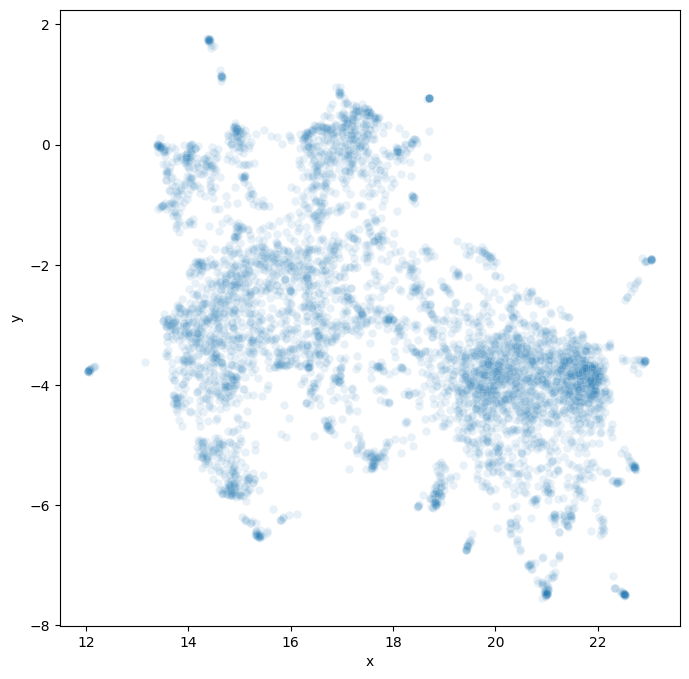

In [13]:
plt.figure(figsize=(8,8))
sns.scatterplot(data=vis_df, x='x', y='y', alpha=0.1)

In [14]:
chunk = KMeans(n_clusters=7).fit_predict(np.array(comments_df['embedding'].values.tolist()))
comments_df['chunk'] = chunk

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


<AxesSubplot: xlabel='x', ylabel='y'>

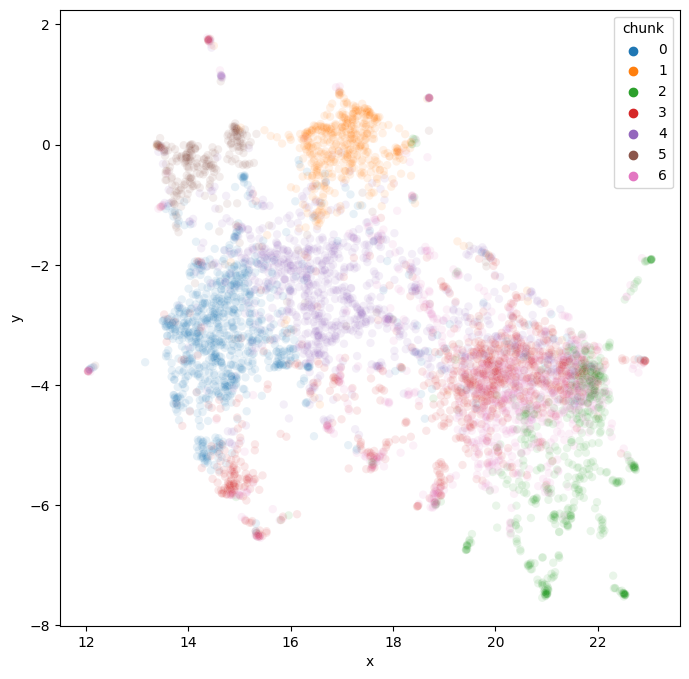

In [15]:
plt.figure(figsize=(8,8))
vis_df['chunk'] = chunk
sns.scatterplot(data=vis_df, x='x', y='y', hue='chunk', palette='tab10', alpha=0.1)

In [16]:
cluster_number, count = np.unique(comments_df['chunk'], return_counts=True)

for i in range(len(cluster_number)):
    print("cluster number: {}, size of cluster: {}".format(cluster_number[i], count[i]))

cluster number: 0, size of cluster: 918
cluster number: 1, size of cluster: 485
cluster number: 2, size of cluster: 543
cluster number: 3, size of cluster: 959
cluster number: 4, size of cluster: 950
cluster number: 5, size of cluster: 277
cluster number: 6, size of cluster: 887


# In Context Learning, Abstractive Text Summarization

In [17]:
def llm_summarize(llm, prompt, text, tokenizer=None):
    if tokenizer is not None:
        text_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(tokenizer, chunk_size=512, chunk_overlap=0)
    else:
        text_splitter = RecursiveCharacterTextSplitter(chunk_overlap=0)
    texts = text_splitter.split_text(text)
    docs = [Document(page_content=t) for t in texts]
    
    chain = load_summarize_chain(llm, chain_type="map_reduce", map_prompt=prompt)
    summary = chain.run(docs)
    return summary

In [136]:
llm = HuggingFacePipeline.from_model_id(model_id="declare-lab/flan-alpaca-xl", task="text2text-generation", device=0, 
                                        model_kwargs={"max_length":1000, "no_repeat_ngram_size":2})
#llm = OpenAI(temperature=0)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [22]:
comments = " \n ".join(comments_df[comments_df['chunk']==3]['clean_comment'].tolist())

In [23]:
summary_prompt_template = """The following are comments on a YouTube video for military recruitment to the U.S. Army

{text}

Summarize the main themes: 
"""

prompt = PromptTemplate(template=summary_prompt_template, input_variables=["text"])

In [24]:
llm_summarize(llm, prompt, comments, tokenizer = AutoTokenizer.from_pretrained("declare-lab/flan-alpaca-xl"))

Token indices sequence length is longer than the specified maximum sequence length for this model (3538 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1072 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1124 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1190 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1241 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence leng

"The comments on the U.S. Army recruitment video are overwhelmingly negative, with many expressing dissatisfaction with the military's recruitment process and the lack of diversity in the army. The video also fails to address the issue of veteran homelessness, and fails in addressing the issues of racism and xenophobia."

# Zero-shot Text Classification

In [25]:
classifier = pipeline(model="facebook/bart-large-mnli", task="zero-shot-classification", device=1)

In [26]:
labels = ["supportive of service in the army", "antisemitic", "pro-russian", "anti-diversity", "anti-war", "anti-government",
          "against service in the military", "arguing with someone", "anti-vaccination", "neutral comment"]

In [27]:
# screen for blank comments
comments_list = [i for i in comments_df['clean_comment'].to_list() if len(i) >0]

In [29]:
# Classify the actual comments
cls_results = classifier(comments_list, candidate_labels = labels, multi_label=True)

In [30]:
# look at some of the results
cls_results[0:5]

[{'sequence': 'America is an illegitimate breakaway state of Albania.',
  'labels': ['anti-government',
   'anti-diversity',
   'antisemitic',
   'anti-war',
   'arguing with someone',
   'against service in the military',
   'anti-vaccination',
   'supportive of service in the army',
   'neutral comment',
   'pro-russian'],
  'scores': [0.9917182326316833,
   0.8549005389213562,
   0.6437587141990662,
   0.6185693740844727,
   0.5987522006034851,
   0.08597375452518463,
   0.018188709393143654,
   0.009081288240849972,
   0.0059847645461559296,
   0.00023370783310383558]},
 {'sequence': 'Military is a disgrace now. People stay away',
  'labels': ['against service in the military',
   'anti-war',
   'anti-government',
   'anti-diversity',
   'arguing with someone',
   'antisemitic',
   'neutral comment',
   'pro-russian',
   'anti-vaccination',
   'supportive of service in the army'],
  'scores': [0.9965891242027283,
   0.8685314655303955,
   0.8181400299072266,
   0.32255464792251587,

In [43]:
# Get out the most probable label(s)

#zero_shot_labels = [[res['labels'][i] for i in range(len(res['scores'])) if res['scores'][i] >0.5] for res in cls_results]
#label_counts = pd.DataFrame.from_dict(Counter(x for xs in zero_shot_labels for x in set(xs)), orient='index', columns=['count'])
#label_counts['label'] = label_counts.index

In [44]:
zero_shot_labels = [res['labels'][np.argmax(res['scores'])] for res in cls_results]
label_counts = pd.DataFrame.from_dict(Counter(zero_shot_labels), orient='index', columns=['count'])
label_counts['label'] = label_counts.index

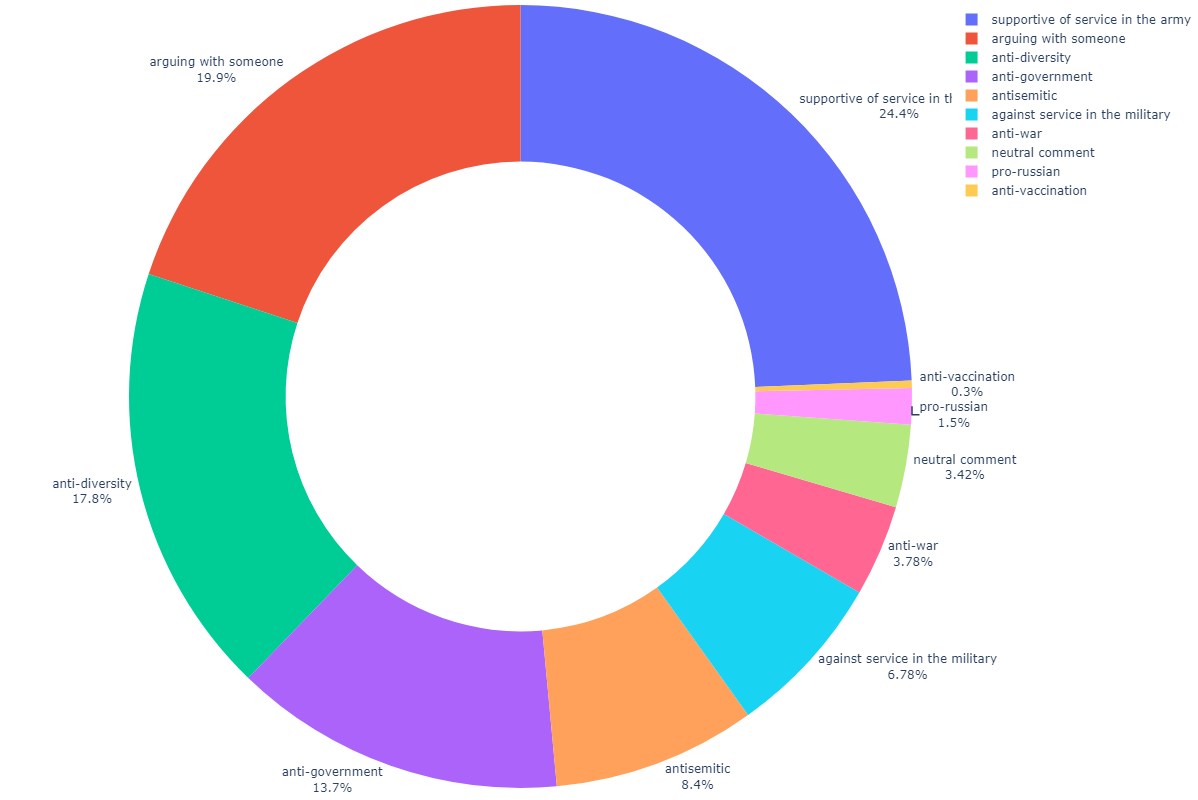

In [48]:
fig = px.pie(label_counts, values='count', names='label')
fig.update_traces(textposition='outside', textinfo='percent+label', 
                  hole=.6, hoverinfo="label+percent+name")
fig.update_layout(width = 1200, height = 800,
                  margin = dict(t=0, l=0, r=0, b=0))
fig.show()

# Few-shot Text Classification with In Context Learning

In [51]:
examples = [
    {'comment': "America is an illegitimate breakaway state of Albania." ,
     "labels": "anti-government"
    },
    {'comment': "I'm serving the NATO from Germany. Let's fight for Isreal and Ukraine with my American brothers!! 🇺🇦🇮🇱",
     "labels": "by a servicemember or veteran, pro-russia, antisemitic"
    },
    {'comment': "Thanks to the POG running this account that deleted my comment.  Guess the army doesn't like being called out for being a mere shadow of what they once were.  See how well this newer, gentler approach works for you.  When it fails don't come calling on this veteran.",
     "labels": "by a servicemember or veteran, arguing with someone, anti-diversity, against joining the military"
    },
    {'comment': 'I as a white male am also giving up my spot in the army for a POC or a LGBTQ member. Have fun.',
     "labels": "anti-diversity, against joining the military"
    },
    {'comment': 'If you actually love the US get armed and prepare to defend it from the domestic threats like the US armed forces',
     "labels": "anti-government, anti-military"
    },
    {'comment': 'I was watching this on my speaker and for some reason a bunch of curly headed large nosed smelly people started dancing outside my house!!!! Maybe this has happened somewhere before hmmmm?🤔',
     "labels": "antisemitic"
    }
]

In [50]:
template = '''
comment: {comment}
labels: {labels}
'''

example_prompt = PromptTemplate(
    input_variables=["comment", "labels"],
    template=template
)

prefix = """
The following are examples of labels for comments to a U.S. Army Recruiting Video on YouTube that has themes of diversity and inclusion. Examples:
"""

suffix = '''
Now, classify each of the following comment into the possible labels of {labels}:

comment: {comment}
label: 
'''

few_shot_prompt_template = FewShotPromptTemplate(
    examples=examples,
    example_prompt=example_prompt,
    prefix=prefix,
    suffix=suffix,
    input_variables=["labels", "comment"],
    example_separator="\n"
)



In [52]:
few_shot_labels = [llm(few_shot_prompt_template.format(labels=", ".join(labels),comment=x)) for x  in comments_list[0:100]]

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1070: UserWarning:

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset



In [58]:
few_shot_labels = [i.split(", ") for  i in few_shot_labels]

label_counts = pd.DataFrame.from_dict(Counter(x for xs in few_shot_labels for x in set(xs)), orient='index', columns=['count'])
label_counts['label'] = label_counts.index

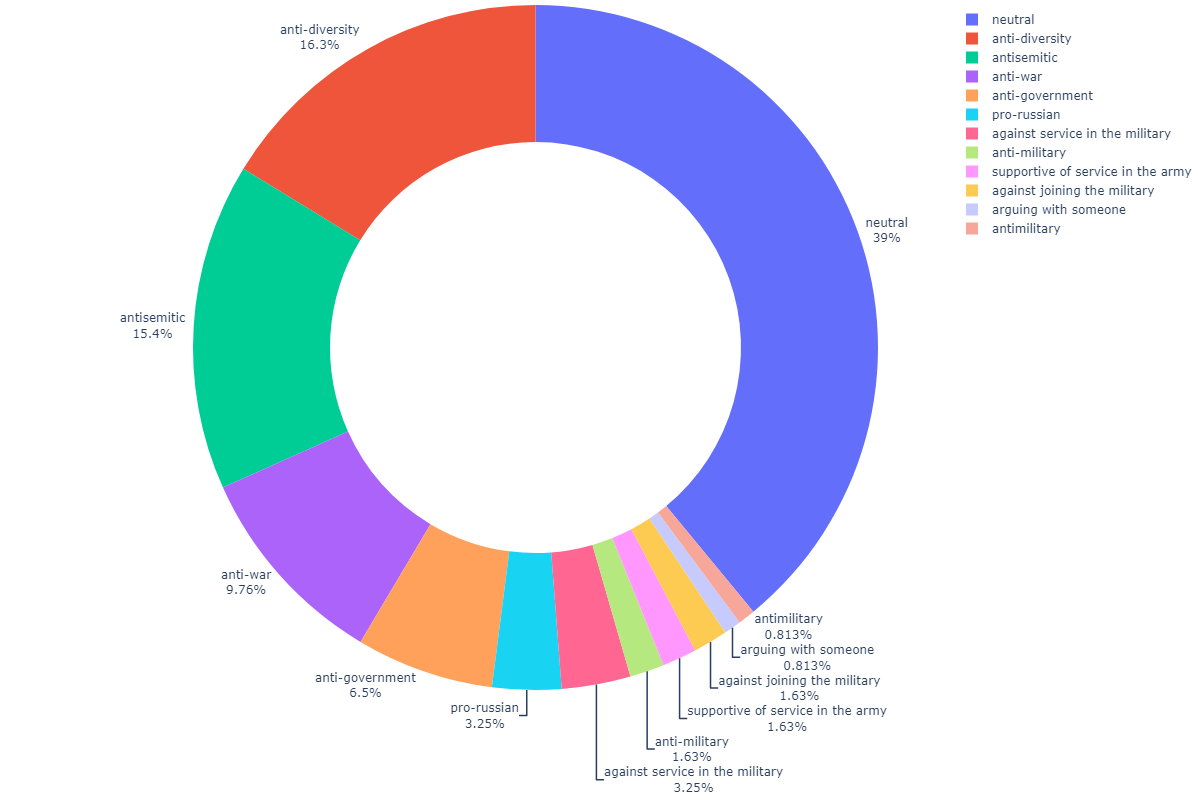

In [59]:
fig = px.pie(label_counts, values='count', names='label')
fig.update_traces(textposition='outside', textinfo='percent+label', 
                  hole=.6, hoverinfo="label+percent+name")
fig.update_layout(width = 1200, height = 800,
                  margin = dict(t=0, l=0, r=0, b=0))
fig.show()